# Predictive Modelling of Claim Frequency and Severity

**Environment setup (run once only):**
```bash
pip install pandas numpy matplotlib scikit-learn

## Library imports

Record the exact package versions for reproducibility and compatibility.  
If updating any dependency, review its changelog and re-run smoke tests.

**This notebook uses:**
- `pandas` — data frames & IO
- `numpy` — numerical arrays & math
- `matplotlib` — plotting
- `scikit-learn` (`sklearn`) — modeling & metrics

> Tip: print `__version__` for each package right after import and save it in the run log.

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sk.__version__)

pandas version: 2.3.3
numpy version: 2.3.4
matplotlib version: 3.10.7
scikit-learn version: 1.7.2


## Importing Data Set using an API

### First we install Kagglehub
#### Run only once, Skip if already installed

In [28]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


## Loading the Dataset using Kaggle API

In [29]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("floser/french-motor-claims-datasets-fremtpl2freq")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rithw\.cache\kagglehub\datasets\floser\french-motor-claims-datasets-fremtpl2freq\versions\1


## Dataset description

**freMTPL2freq** contains 11 columns (+ `IDpol`):

- **IDpol** – Policy ID (links with the claims dataset)
- **ClaimNb** – Number of claims during the exposure period
- **Exposure** – The exposure period (in years)
- **Area** – Area code
- **VehPower** – Power of the car (ordered categorical)
- **VehAge** – Vehicle age (in years)
- **DrivAge** – Driver age (in years)
- **BonusMalus** – Bonus/malus factor (50–350): <100 = bonus, >100 = malus
- **VehBrand** – Car brand
- **VehGas** – Car fuel type (Diesel or Regular)
- **Density** – Population density (inhabitants per km²)
- **Region** – Policy region in France (standard French classification)


[WindowsPath('C:/Users/rithw/.cache/kagglehub/datasets/floser/french-motor-claims-datasets-fremtpl2freq/versions/1/freMTPL2freq.csv')]
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0        1      0.10    D         5       0       55          50   
1    3.0        1      0.77    D         5       0       55          50   
2    5.0        1      0.75    B         6       2       52          50   
3   10.0        1      0.09    B         7       0       46          50   
4   11.0        1      0.84    B         7       0       46          50   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel       76    R72  
4      B12   Diesel       76    R72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------  

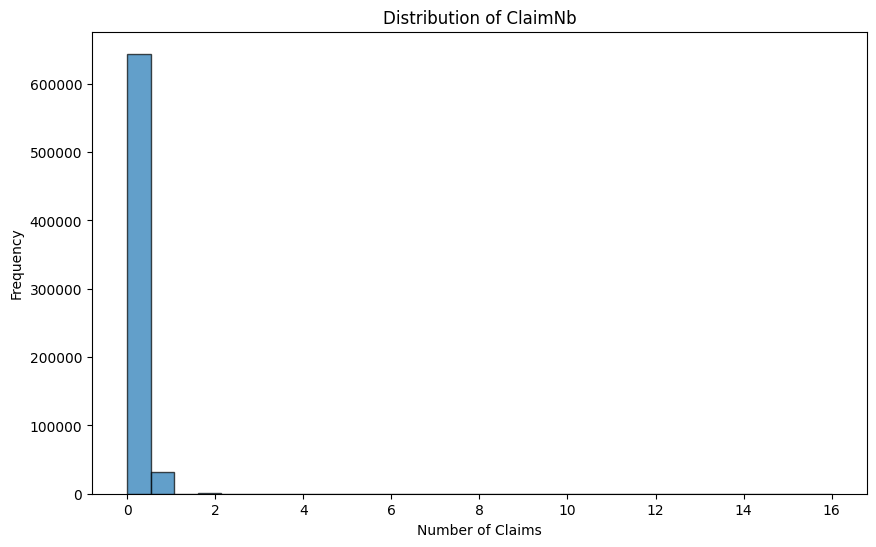

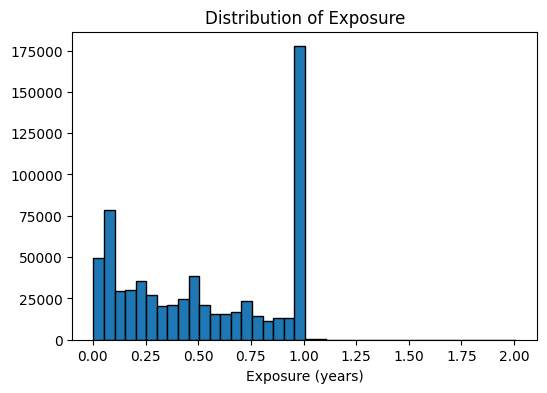

Policies with Exposure >1.2: 203 (0.03%)
Dataset shape after removing invalid exposures: (677810, 12)


In [30]:
from pathlib import Path

# Path to the dataset folder
data_path = Path(r"C:\Users\rithw\.cache\kagglehub\datasets\floser\french-motor-claims-datasets-fremtpl2freq\versions\1")

# List CSVs in that folder (for verification)
print(list(data_path.glob("*.csv")))

# Load the frequency dataset
df = pd.read_csv(data_path / "freMTPL2freq.csv")

# Preview first few rows
print(df.head(5))

# Get dataset info
print(df.info())

# Summary statistics
print(df.describe())

# Shape of the dataset

print("Dataset shape:", df.shape)

# Check for missing values
print(df.isnull().sum())

# Distribution of the target variable 'ClaimNb'
plt.figure(figsize=(10,6))
plt.hist(df['ClaimNb'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of ClaimNb')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["Exposure"], bins=40, edgecolor="k")
plt.title("Distribution of Exposure")
plt.xlabel("Exposure (years)")
plt.show()

# Flag unusual exposures
invalid = df[df["Exposure"] > 1.2]
print(f"Policies with Exposure >1.2: {len(invalid)} ({len(invalid)/len(df):.2%})")

# Remove invalid exposures
df = df[df["Exposure"] <= 1.2]
print("Dataset shape after removing invalid exposures:", df.shape)


Zero-claim policies: 94.98%
One-claim policies : 4.75%
Mean claim frequency: 0.0532 claims per policy
Mean exposure: 0.5285 years
Claim frequency per year of exposure: 0.1007 claims per policy-year
Minimum driver age: 18
Maximum driver age: 100
Rows with DrivAge < 18: 0
Dataset shape after filtering: (677810, 12)
BonusMalus range: 50 to 230
Rows with invalid BonusMalus: 0
Unique values in VehGas: ['Regular' 'Diesel']
VehGas
Regular    51.015771
Diesel     48.984229
Name: proportion, dtype: float64


<Figure size 1000x600 with 0 Axes>

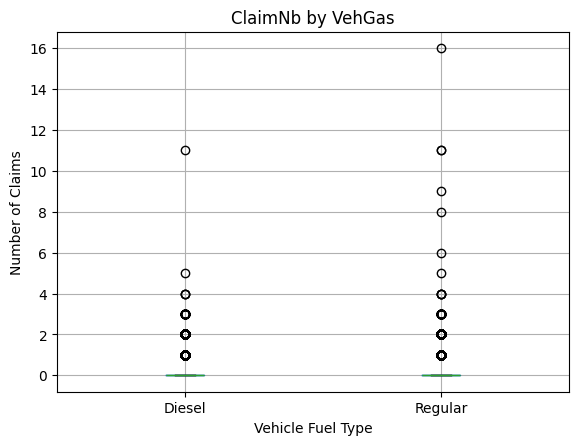

Mean claim frequency by VehGas:
VehGas
Diesel     0.050136
Regular    0.056228
Name: ClaimNb, dtype: float64


In [31]:
# Calculate and print percentage of zero-claim and one-claim policies
zero_pct = (df["ClaimNb"] == 0).mean()*100
one_pct  = (df["ClaimNb"] == 1).mean()*100
print(f"Zero-claim policies: {zero_pct:.2f}%")
print(f"One-claim policies : {one_pct:.2f}%")

# Calculate and print mean claim frequency
mean_freq = df["ClaimNb"].mean()
print(f"Mean claim frequency: {mean_freq:.4f} claims per policy")

# Calculate and print mean exposure
mean_expo = df["Exposure"].mean()
print(f"Mean exposure: {mean_expo:.4f} years")

# Calculate and print claim frequency per year of exposure
freq_per_year = mean_freq / mean_expo
print(f"Claim frequency per year of exposure: {freq_per_year:.4f} claims per policy-year")

# Check minimum and distribution
print("Minimum driver age:", df["DrivAge"].min())
print("Maximum driver age:", df["DrivAge"].max())

# Identify any invalid ages
invalid_age = df[df["DrivAge"] < 18]
print(f"Rows with DrivAge < 18: {len(invalid_age)}")

# If any exist, remove them
df = df[df["DrivAge"] >= 18].copy()
print("Dataset shape after filtering:", df.shape)

print("BonusMalus range:", df["BonusMalus"].min(), "to", df["BonusMalus"].max())

# Identify out-of-range entries
invalid_bm = df[(df["BonusMalus"] < 50) | (df["BonusMalus"] > 350)]
print(f"Rows with invalid BonusMalus: {len(invalid_bm)}")

# Unique fuel types
print("Unique values in VehGas:", df["VehGas"].unique())

# Frequency table
print(df["VehGas"].value_counts(normalize=True) * 100)

# Boxplot of ClaimNb by VehGas
plt.figure(figsize=(10,6))
df.boxplot(column="ClaimNb", by="VehGas")
plt.title("ClaimNb by VehGas")
plt.suptitle("")
plt.xlabel("Vehicle Fuel Type")
plt.ylabel("Number of Claims")
plt.show()
# Calculate and print mean claim frequency by VehGas
mean_freq_by_gas = df.groupby("VehGas")["ClaimNb"].mean()
print("Mean claim frequency by VehGas:")
print(mean_freq_by_gas)

Density summary:
count    677810.000000
mean       1792.336075
std        3958.505278
min           1.000000
25%          92.000000
50%         393.000000
75%        1658.000000
max       27000.000000
Name: Density, dtype: float64


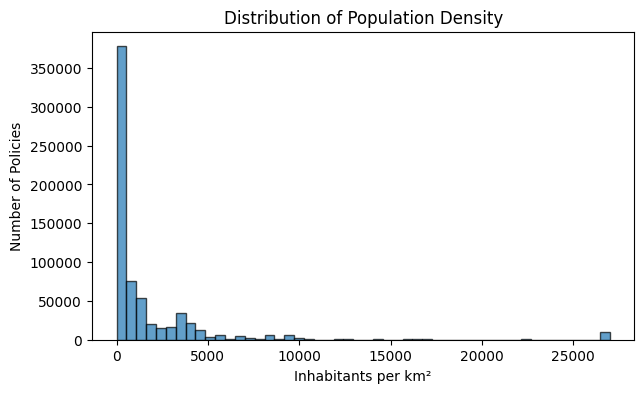

Policies with Density > 10,000: 17949 (2.65%)


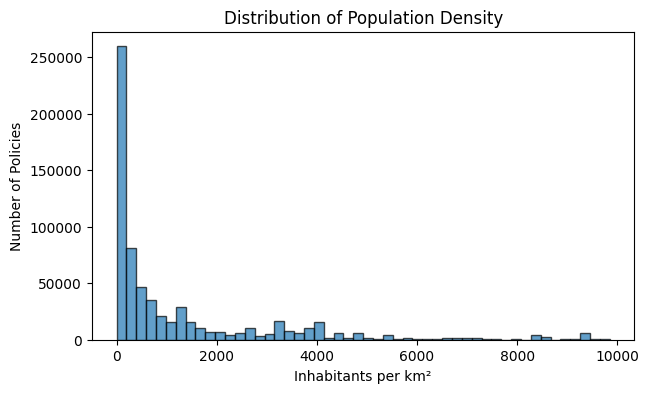

In [32]:
print("Density summary:")
print(df["Density"].describe())

plt.figure(figsize=(7,4))
plt.hist(df["Density"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribution of Population Density")
plt.xlabel("Inhabitants per km²")
plt.ylabel("Number of Policies")
plt.show()

# Identify outliers in Density
high_density = df["Density"] > 10000
print(f"Policies with Density > 10,000: {high_density.sum()} ({high_density.mean():.2%})")
plt.figure(figsize=(7,4))
plt.hist(df.loc[~high_density, "Density"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribution of Population Density")
plt.xlabel("Inhabitants per km²")
plt.ylabel("Number of Policies")
plt.show()

Unique regions (22): ['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41', 'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82', 'R83', 'R91', 'R93', 'R94']
Region
R24    23.693070
R82    12.500553
R93    11.691477
R11    10.294478
R53     6.214426
R52     5.715761
R91     5.277438
R72     4.620911
R31     4.023104
R54     2.809932
Name: proportion, dtype: float64


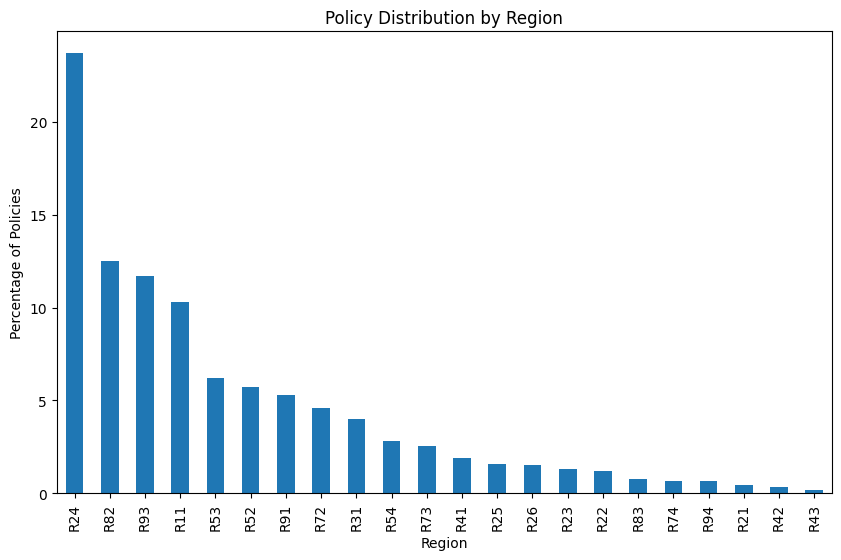

In [33]:
regions = df["Region"].unique()
print(f"Unique regions ({len(regions)}): {sorted(regions)}")

# Count by region
region_counts = df["Region"].value_counts(normalize=True) * 100
print(region_counts.head(10))
plt.figure(figsize=(10,6))
region_counts.plot(kind="bar")
plt.title("Policy Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Percentage of Policies")
plt.show()


### Data Cleaning Summary

**Exposure**
- 203 policies with exposure > 1.2 years were removed to maintain consistency with the annual exposure definition.
- Final dataset reduced from **678 013 → 677 810** rows (–0.03 %).

**DrivAge**
- No entries below 18 years; all compliant with the legal French driving age.

**BonusMalus**
- All values lie within the expected **[50, 230]** range, consistent with the French bonus–malus scale.
- <100 → bonus (good drivers); >100 → malus (surcharged risk).

**VehGas**
- Only two valid fuel types: *Diesel* and *Regular* — both consistently capitalised and used.

**Density**
- Range 1 – 27 000 inh/km²; right-skewed but plausible.
- Will consider `log_Density = log(1 + Density)` for model stability.

**Region**
- 22 distinct region codes (`R11 … R94`), all **consistently ordered and numbered** in line with standard French regional classification.
- No missing, malformed, or duplicated codes detected.

**Result**
- Dataset is **complete, internally consistent, and regulation-compliant.**
- Ready for feature engineering and modelling (frequency → severity → pure-premium).

## Core Principle of Insurance Pricing

The goal of insurance pricing is to estimate the **expected total cost** of an insurance policy — that is, the expected monetary outflow from the insurer to the insured.

In general, there are two key random variables governing this cost:  
1. **Frequency** — the number of claims that occur within a policy period.  
2. **Severity** — the monetary amount of each claim that occurs.

Hence, the expected total claim cost per policy can be expressed as:

$$
\mathbb{E}[\text{Cost}] = \mathbb{E}[\text{Frequency of Claims}] \times \mathbb{E}[\text{Severity of Claims}]
$$

Given historical data, we can estimate both frequency and severity conditional on the characteristics of each insured entity.  
This is the foundation of **predictive modelling in insurance**.

---

### Stochastic Interpretation

If we were to observe the insurance portfolio as an isolated stochastic system over infinite time, the **Law of Large Numbers** implies that empirical averages of observed claim frequencies and severities converge to their respective expectations.  

In other words, as the number of policies or observation time increases:

$$
\frac{1}{n} \sum_{i=1}^{n} N_i \to \mathbb{E}[N], \quad
\frac{1}{n} \sum_{i=1}^{n} Y_i \to \mathbb{E}[Y]
$$

where $ N_i $ is the claim count and $ Y_i $ is the claim cost for policy $ i $.

---

### Analogy with Stochastic Processes

This system can be thought of as a *random counting process* over time — somewhat analogous to Brownian motion, but instead of continuous symmetric fluctuations, we have **discrete jumps** (claims) occurring at random intervals.

- The **claim arrival process** is typically modelled as a **Poisson process**, representing random, independent events over time.  
- The **inter-arrival times** between claims follow an **Exponential** (or more generally, **Gamma**) distribution.  
- The **claim sizes** themselves follow a **continuous**, right-skewed distribution such as **Gamma** or **Log-normal**, capturing many small claims and few large ones.

Thus, in modelling terms:
- The *frequency* process answers: *“How many claims occur in a given time interval?”*  
- The *severity* process answers: *“How large are those claims when they occur?”*

Together, they form a **compound stochastic process**, often written as:

$$
S = \sum_{j=1}^{N} Y_j
$$

where $ S $ is the total cost, $ N \sim \text{Poisson}(\lambda) $, and $ Y_j \sim \text{Gamma}(\alpha, \theta) $.  
This leads naturally to the **Tweedie distribution**, which models the total cost directly.
